<a href="https://colab.research.google.com/github/leosalves1/IEEE-CIS-Treinamento/blob/main/2%C2%B0_Per%C3%ADodo_CIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Sobre o Data Set:

This dataset contains the first 10min. stats of approx. 10k ranked games (SOLO QUEUE) from a high ELO (DIAMOND I to MASTER). Players have roughly the same level.

Each game is unique. The gameId can help you to fetch more attributes from the Riot API.


The column blueWins is the target value (the value we are trying to predict). A value of 1 means the blue team has won. 0 otherwise.

## Glossary
Warding totem: An item that a player can put on the map to reveal the nearby area. Very useful for map/objectives control.

Minions: NPC that belong to both teams. They give gold when killed by players.

Jungle minions: NPC that belong to NO TEAM. They give gold and buffs when killed by players.

Elite monsters: Monsters with high hp/damage that give a massive bonus (gold/XP/stats) when killed by a team.

Dragons: Elite monster which gives team bonus when killed. The 4th dragon killed by a team gives a massive stats bonus. The 5th dragon (Elder Dragon) offers a huge advantage to the team.

Herald: Elite monster which gives stats bonus when killed by the player. It helps to push a lane and destroys structures.

Towers: Structures you have to destroy to reach the enemy Nexus. They give gold.

Level: Champion level. Start at 1. Max is 18.

In [257]:
df = pd.read_csv('/content/drive/MyDrive/Datasets_CIS/high_diamond_ranked_10min.csv')
df

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,0,0,17765,7.2,18967,211,69,2519,2469,21.1,1776.5,46,3,0,4,7,7,0,0,0,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,4527797466,1,54,0,0,6,4,8,1,1,0,0,16238,7.2,19255,233,48,782,888,23.3,1623.8,12,21,1,4,6,3,0,0,0,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,4527713716,0,23,1,0,6,7,5,0,0,0,0,15903,7.0,18032,210,45,-2416,-1877,21.0,1590.3,14,0,1,7,6,11,1,1,0,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,0,0,14459,6.6,17229,224,48,-839,-1085,22.4,1445.9,66,4,0,3,2,1,0,0,0,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


# Análise qualitativa do dataset
Num primeiro momento, não vi necessidade de tratar o dataset, visto que não há valores faltantes e nem dados categóricos nominais, nem há unidades conflitantes. Porém, depois de pesquisar mais, acabei me deparando com a seguinte situação:


> A coluna gameId não serve para análise estatística.

> Se o time azul obtiver um abate, o time vermelho sofrerá uma morte. O inverso também é verdade.

> Se o time azul obtiver o primeiro abate (first blood) da partida, o time vermelho não poderá conseguir o primeiro abate.

> As diferenças de ouro e experiências são iguais, porém com sinais invertidos.

então posso retirar certas colunas e diminuir o tamanho do dataset.



In [259]:
#provando os pontos acima
all((df['blueFirstBlood'] & df['redFirstBlood']) == 1)

False

In [260]:
all(df['blueKills'] == df['redDeaths'])

True

In [261]:
all(df['blueGoldDiff'] == (-df['redGoldDiff']))

True

In [262]:
df.drop(['redFirstBlood', 'redKills', 'redDeaths', 'redGoldDiff', 'redExperienceDiff', 'gameId'], axis = 1, inplace = True)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,8,0,0,0,0,16567,6.8,17047,197,55,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,2,2,1,1,1,17620,6.8,17438,240,52,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,14,0,0,0,0,17285,6.8,17254,203,28,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,10,0,0,0,0,16478,7.0,17961,235,47,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,7,1,1,0,0,17404,7.0,18313,225,67,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,0,17765,7.2,18967,211,69,2519,2469,21.1,1776.5,46,3,7,0,0,0,0,15246,6.8,16498,229,34,22.9,1524.6
9875,1,54,0,0,6,4,8,1,1,0,0,16238,7.2,19255,233,48,782,888,23.3,1623.8,12,21,3,0,0,0,0,15456,7.0,18367,206,56,20.6,1545.6
9876,0,23,1,0,6,7,5,0,0,0,0,15903,7.0,18032,210,45,-2416,-1877,21.0,1590.3,14,0,11,1,1,0,0,18319,7.4,19909,261,60,26.1,1831.9
9877,0,14,4,1,2,3,3,1,1,0,0,14459,6.6,17229,224,48,-839,-1085,22.4,1445.9,66,4,1,0,0,0,0,15298,7.2,18314,247,40,24.7,1529.8


# Normalizando o DataSet

In [263]:
#Ajustando pra analisar os dois times com relação a kills e nível médio
df_both = df[['blueKills', 'blueDeaths', 'blueAssists', 'blueAvgLevel','redAssists', 'redAvgLevel']]
col_names  = list(df_both.columns)
df_both

,blueKills,blueDeaths,blueAssists,blueAvgLevel,redAssists,redAvgLevel
0,9,6,11,6.6,8,6.8
1,5,5,5,6.6,2,6.8
2,7,11,4,6.4,14,6.8
3,4,5,5,7.0,10,7.0
4,6,6,6,7.0,7,7.0
...,...,...,...,...,...,...
9874,7,4,5,7.2,7,6.8
9875,6,4,8,7.2,3,7.0
9876,6,7,5,7.0,11,7.4
9877,2,3,3,6.6,1,7.2


In [264]:
#normalizando
from sklearn.preprocessing import StandardScaler

df_both_norm = StandardScaler().fit_transform(df_both)
df_both_norm = pd.DataFrame(df_both_norm, columns = col_names)
df_both_norm

,blueKills,blueDeaths,blueAssists,blueAvgLevel,redAssists,redAvgLevel
0,0.935301,-0.046926,1.071495,-1.035635,0.329496,-0.410475
1,-0.393216,-0.387796,-0.404768,-1.035635,-1.148188,-0.410475
2,0.271042,1.657424,-0.650812,-1.691092,1.807181,-0.410475
3,-0.725346,-0.387796,-0.404768,0.275280,0.822058,0.244627
4,-0.061087,-0.046926,-0.158724,0.275280,0.083215,0.244627
...,...,...,...,...,...,...
9874,0.271042,-0.728666,-0.404768,0.930738,0.083215,-0.410475
9875,-0.061087,-0.728666,0.333364,0.930738,-0.901908,0.244627
9876,-0.061087,0.293944,-0.404768,0.275280,1.068338,1.554831
9877,-1.389604,-1.069536,-0.896856,-1.035635,-1.394469,0.899729


# Aplicando PCA


In [265]:
from sklearn.decomposition import PCA

#montado o dataframe com PCAs
n_comp = 3
pca = PCA(n_components= n_comp)
principalComponents = pca.fit_transform(df_both_norm)
pca_both_norm = pd.DataFrame(data = principalComponents, columns = ['principal component '+str(i+1) for i in range(n_comp)])

pca_both_norm

,principal component 1,principal component 2,principal component 3
0,-0.427543,1.181501,0.983738
1,-0.003720,-1.125898,0.991682
2,2.058100,1.612338,1.380050
3,0.595057,-0.359566,-0.241077
4,0.084266,-0.105401,-0.355039
...,...,...,...
9874,-0.799600,-0.407319,-0.311377
9875,-1.041104,-0.717566,-0.790369
9876,1.247493,0.405382,-1.272698
9877,0.781894,-2.365421,0.159593


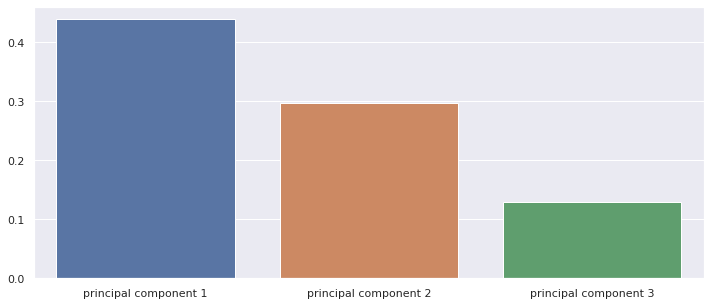

In [266]:
#Visualizando a relevância dos principal components
values_pca = pca.explained_variance_ratio_
names = list(pca_both_norm.columns)

sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(12,5)})

sns.barplot(x = names, y = values_pca)
plt.show()

In [267]:
pca.explained_variance_ratio_

array([0.43880608, 0.29755015, 0.12977509])

Assim percebemos que, durante a redução de dimensões (6 para 3), houve uma perda de informação, mas ainda sobra informação suficiente para tirar a seguinte conclusão:

> Analisar as eliminações, mortes e assistências somado à média de nível aos 10 minutos de um jogo ranqueado de League of Legends do Diamante 1 (um ranking relativamente alto) nos dá a possibilidade de prever pouco mais de 85% do resultado dos jogos.

Primeiro testei esse dataframe com as colunas de WardsPlaced e WardsDestroyed, uma vez que o controle de visão no jogo é um elemento estratégico poderoso, que te permite ver a movimentação do oponente e tirar alguma vantagem disso. Porém, como esse dado é extremamente variável dependendo do jogador que o obtém (por exemplo, um jogador mais proativo pode utilizar a visão melhor que outro jogador mais passivo), acabava por ter uma variância muito mais distribuída entre os Principal Components. Isso me leva a crer que o controle de visão no começo do jogo não é tão relevante quanto esses outros fatores, mas não sei como provar isso. 

# Criando modelo, treinando e testando

Aqui a ideia é trabalhar em torno dos objetivos no começo do jogo (Dragons, Herald e Torres)

In [268]:
df_both_obj = df[['blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'redDragons', 'redHeralds', 'redTowersDestroyed',]]
df_both_obj

,blueDragons,blueHeralds,blueTowersDestroyed,redDragons,redHeralds,redTowersDestroyed
0,0,0,0,0,0,0
1,0,0,0,1,1,1
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
9874,1,0,0,0,0,0
9875,1,0,0,0,0,0
9876,0,0,0,1,0,0
9877,1,0,0,0,0,0


In [269]:
#separando os dados pro modelo
df_both_obj = pd.concat([df_both, df['blueWins']], axis=1)
x_data = df_both_obj.drop('blueWins', axis=1)
y_data = df_both_obj['blueWins']

In [270]:
#separando os dados entre dados de treino e validação
from sklearn.model_selection import train_test_split

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.25)

In [271]:
#efetivamente treinando o modelo
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_training_data, y_training_data)

predictions = model.predict(x_test_data)

In [272]:
#resultado das previsões
from sklearn import metrics

print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1251
           1       0.72      0.71      0.71      1219

    accuracy                           0.72      2470
   macro avg       0.72      0.72      0.72      2470
weighted avg       0.72      0.72      0.72      2470



In [273]:
#matriz de confusão para uma outra visualização das previsões
cnf_matrix = metrics.confusion_matrix(y_test_data, predictions)
cnf_matrix

array([[910, 341],
       [356, 863]])

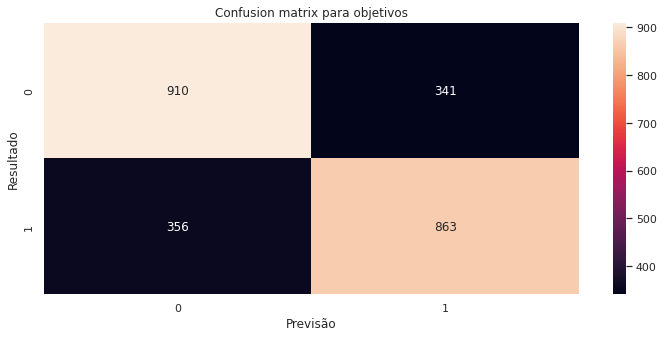

In [274]:
#visualização gráfica das previsões.
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g')
plt.title('Confusion matrix para objetivos')
plt.ylabel('Resultado')
plt.xlabel('Previsão')
plt.show()

Depois de treinar e ver as previsões, percebemos também uma taxa de acerto por volta de 74%.

Durante um jogo de League of Legends, normalmente o time que pega o primeiro Herald abre uma vantagem de ouro que, dependendo da situação pode acabar sendo suficiente para ditar o ritmo da partida e ganhar o jogo, então esse resultado condiz com a realidade.

Para testar isso, vou testar substituir pela coluna de EliteMonsters as colunas de Dragons e Heralds.

# Segundo modelo

In [275]:
df_both_obj2 = df[['blueEliteMonsters', 'blueTowersDestroyed', 'redEliteMonsters', 'redTowersDestroyed']]
df_both_obj2

,blueEliteMonsters,blueTowersDestroyed,redEliteMonsters,redTowersDestroyed
0,0,0,0,0
1,0,0,2,1
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
9874,1,0,0,0
9875,1,0,0,0
9876,0,0,1,0
9877,1,0,0,0


In [276]:
#separando os dados pro modelo
df_both_obj2 = pd.concat([df_both, df['blueWins']], axis=1)
x_data2 = df_both_obj2.drop('blueWins', axis=1)
y_data2 = df_both_obj2['blueWins']

In [277]:
#separando os dados entre dados de treino e validação
from sklearn.model_selection import train_test_split

x_training_data2, x_test_data2, y_training_data2, y_test_data2 = train_test_split(x_data2, y_data2, test_size = 0.25)

In [278]:
#efetivamente treinando o modelo
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()
model2.fit(x_training_data, y_training_data)

predictions2 = model2.predict(x_test_data)

In [279]:
#resultado das previsões
from sklearn import metrics

print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1251
           1       0.72      0.71      0.71      1219

    accuracy                           0.72      2470
   macro avg       0.72      0.72      0.72      2470
weighted avg       0.72      0.72      0.72      2470



Olhando a porcentagem de precisão, não fez diferença significativa trocar as colunas.